***

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random Forest</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
import lightgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import SCORERS
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
display(df.head())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Столбец `datetime` содержит информацию о дате и времени, на который совершено определенное количество заказов. Количество заказов находится в столбце `num_orders`.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Таблица содержит 26 496 строк и 2 столбца. Ясных пропустов в данных нет. Типы данных столбцов: строковый `object` и  целочисленный `int64`.

 Проверка наличия пропусков:

In [5]:
print(df[df.isna() == True].sum())

datetime        0
num_orders    0.0
dtype: object


Явных пропусков не онаружено

Проверка наличия дубликатов:

In [6]:
print('Количество дубликатов в исходной таблице: {}'.format(df.duplicated().sum()))

Количество дубликатов в исходной таблице: 0


In [7]:
print('Количество дубликатов столбца datetime:', df['datetime'][df['datetime'].duplicated()].sum())

Количество дубликатов столбца datetime: 0


In [8]:
df.sort_index(inplace=True)

In [9]:
display(df.head())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Text(0.5, 1.0, 'Data')

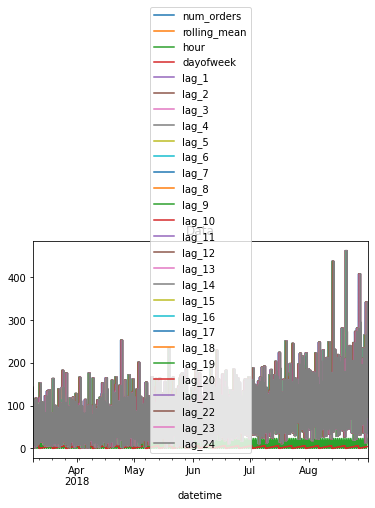

In [65]:
df.plot()
plt.title('Data')

Минимальное количество заказов на момент времени - 0, максимальное  - 119. Явных странностей в данных не обнаружено.

 **Вывод:** Данные загружены и изучены. Таблица исследована на наличие пропусков и дубликатов. На первый взгляд странностей в данных не выявлено.  

## Анализ

In [11]:
unusual_datetime_raws = []
for i in  range(len(df['datetime'])):
    if len(df.iloc[i]['datetime']) < 19:
        unusual_datetime_raws.append(df.iloc[i]['datetime'])

if len(unusual_datetime_raws) != 0:
    print(unusual_datetime_raws)
else:
    print("В столбце datetime данных аномальной длинны не обнаружено.")

В столбце datetime данных аномальной длинны не обнаружено.


Скорее всего с данными в datetime все впорядке.

Изучение статистических данных исходной таблицы:

In [12]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


В среднем происходщит 14 вызовов каждые 10 минут. 75% данных о заказах составляет менее 19 заказов каждые 10 минут. Максимальное число заказов в 10 минутный ромежуток - 119 заказов, минимальное - 0.

Установление `datetime` в качестве индексации таблицы

In [13]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

Ресемплинг данных по одному часу:

In [14]:
# df = df['2018-06-01':'2018-06-30'].resample('1H').sum()
df = df.resample('1H').sum()

Text(0.5, 1.0, 'Taxi orders')

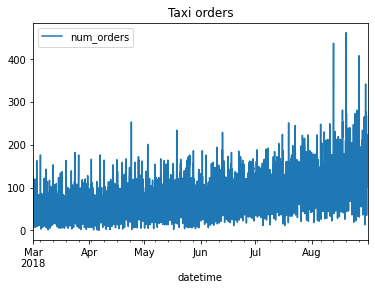

In [15]:
df.plot()
plt.title('Taxi orders')

In [16]:
df['rolling_mean'] = df.rolling(144).mean()

Text(0.5, 1.0, 'Taxi orders')

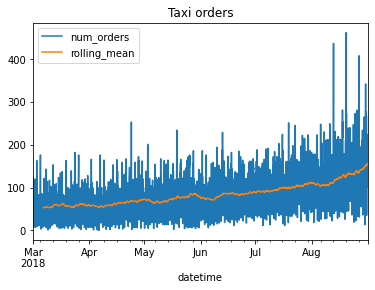

In [17]:
df.plot()
plt.title('Taxi orders')

**Вывод:** Временной ряд нестационарный, так как прослеживается явный рост среднего. Значит, его распределение со временем меняется и делать прогнозирование невозможно.

In [18]:
print(df[df.isna() == True].count())

num_orders      0
rolling_mean    0
dtype: int64


In [19]:
print(df[df.isin([np.inf, -np.inf]) == True].count())

num_orders      0
rolling_mean    0
dtype: int64


In [20]:
np.isfinite(np.array(df))

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [21]:
display(df.head())

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN


In [22]:
df = df.dropna()

Исследуем сезонность и тренды по некоторым месяцам:

Март

In [23]:
df_march = df['2018-03-01':'2018-03-31']

In [24]:
decomposed = seasonal_decompose(df_march['num_orders'])

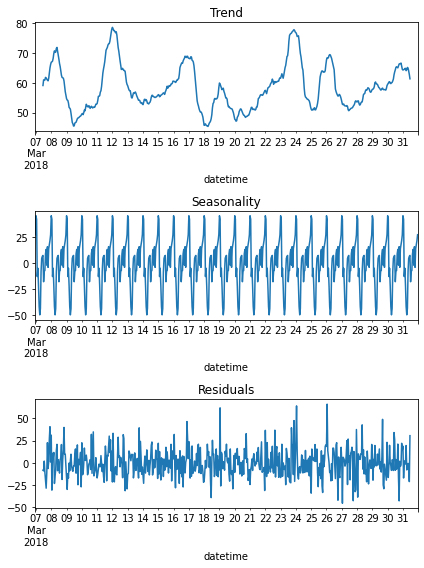

In [25]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Вывод:** В определенные дни заказов больше, в другие - их почти нет, необходимо дальнейшее более детальное исследование

In [26]:
df_15_march = df['2018-03-13':'2018-03-16']

In [27]:
decomposed = seasonal_decompose(df_15_march['num_orders'])

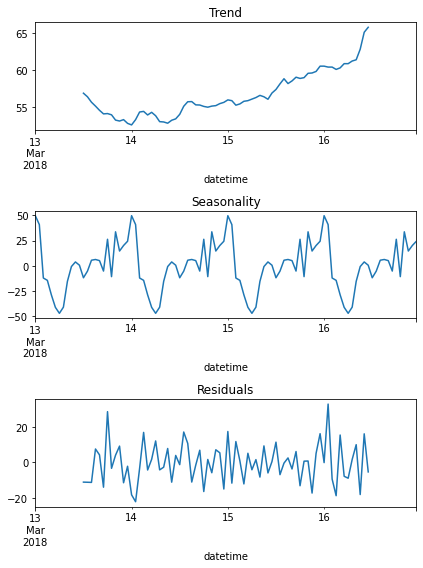

In [28]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Вывод:** Имеется тренд роста заказов в исследуемое время в середине марта. Также наблюдается сезонность: пик заказов приходится на полночь, а минимум - в районе 6 утра.

Июль

In [29]:
df_july = df['2018-07-01':'2018-07-30']

In [30]:
decomposed = seasonal_decompose(df_july['num_orders'])

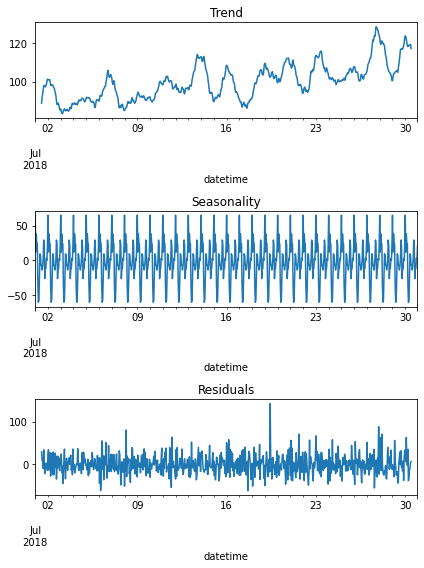

In [31]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [32]:
df_15_jule = df['2018-07-13':'2018-07-16']

In [33]:
decomposed = seasonal_decompose(df_15_jule['num_orders'])

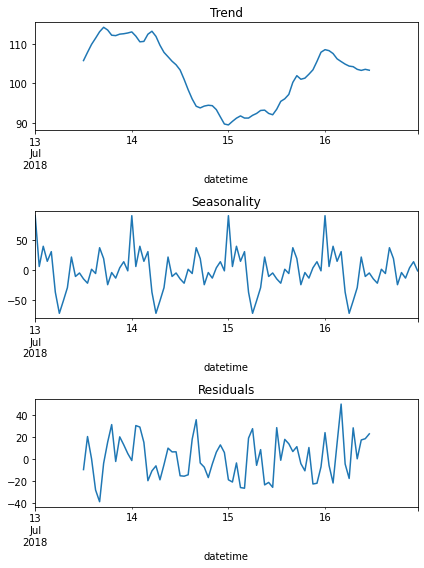

In [34]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Вывод:** В середине июля также наблюдается сезонность: пик заказов приходится на полночь, а минимум - в районе 6 утра. Тренд неясен.

Чтобы ряд сделать стационарным, найдём разности его значений.

In [35]:
df_modified = df - df.shift(fill_value=0)

Text(0.5, 1.0, 'Taxi orders with mean and std')

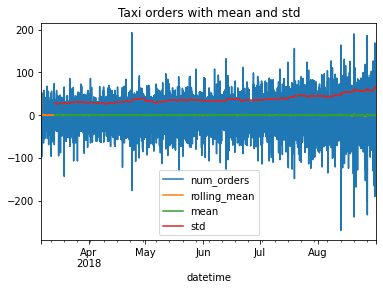

In [36]:
df_modified['mean'] = df_modified['num_orders'].rolling(170).mean()
df_modified['std'] = df_modified['num_orders'].rolling(170).std()
df_modified.plot()
plt.title('Taxi orders with mean and std')

Ряд стационарный, и теперь данные можно прогнозировать.

In [37]:
def make_features(data, lag_col_name, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['rolling_mean'] = data[lag_col_name].shift().rolling(rolling_mean_size).mean()

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[lag_col_name].shift(lag)


In [38]:
make_features(df, 'num_orders', 24, 48)

In [39]:
df = df.dropna()

In [40]:
display(df.head())

,num_orders,rolling_mean,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 23:00:00,79,63.916667,23,3,88.0,86.0,114.0,72.0,81.0,41.0,...,77.0,19.0,6.0,6.0,60.0,68.0,65.0,78.0,143.0,94.0
2018-03-09 00:00:00,84,64.583333,0,4,79.0,88.0,86.0,114.0,72.0,81.0,...,97.0,77.0,19.0,6.0,6.0,60.0,68.0,65.0,78.0,143.0
2018-03-09 01:00:00,66,64.250000,1,4,84.0,79.0,88.0,86.0,114.0,72.0,...,68.0,97.0,77.0,19.0,6.0,6.0,60.0,68.0,65.0,78.0
2018-03-09 02:00:00,29,63.104167,2,4,66.0,84.0,79.0,88.0,86.0,114.0,...,80.0,68.0,97.0,77.0,19.0,6.0,6.0,60.0,68.0,65.0
2018-03-09 03:00:00,31,63.208333,3,4,29.0,66.0,84.0,79.0,88.0,86.0,...,48.0,80.0,68.0,97.0,77.0,19.0,6.0,6.0,60.0,68.0


По исходным данным создадим обучающую и тестовую выборки. В соответствии с условиями заказчика разделяем тестовую выборку к тренировочной в соотношении 1:9


In [41]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

#Проверка корректности деления:

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-08 23:00:00 2018-08-14 08:00:00
2018-08-14 09:00:00 2018-08-31 23:00:00


Тренировочная выборка заканчивается 14 августа в 3 утра, тестовая начинается в 4 утра этого дня. Данные разделены корректно.


In [42]:
X_train = train.drop(['num_orders'], axis= 1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis= 1)
y_test = test['num_orders']

Далее получим предсказания на тренировочной и тестовой выборках

**Вывод:** Таблица исследована на аномальные значения, которых не обнаружено. Столбец даты и времени задан в качестве индексов, проведен ресемплинг данных по 1 часу. Общий тренд говорит об увеличении количества заказов к лету. Ежедневная сезонность: в полночь наблуюается пик числа ежечасных заказов, в районе 6 утра - минимум заказов. Созданы дополнительные календарные признаки и признаки отстающих значений и признак скользящего среднего. Данные разделены на обучающую и тренировочную выборки и готовы к обучению моделей.

## Обучение

**Задача прогнозирования:** нужно спрогнозировать количество заказов такси на следующий час

### Линейная регрессия

In [43]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [44]:
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

In [45]:
# Определение гиперпараметров
params = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

# Создание модели и объекта GridSearchCV
model = LinearRegression()
grid = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', verbose=4)

# Обучение модели на тренировочных данных
grid.fit(X_train, y_train)

LR_grid_params = grid.best_params_

# Вывод лучших гиперпараметров и соответствующего значения метрики
print("Best parameters: ", grid.best_params_)
print("Best score: ", round(np.sqrt(-grid.best_score_)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............fit_intercept=True, normalize=True; total time=   0.3s
[CV 2/5] END .............fit_intercept=True, normalize=True; total time=   0.2s
[CV 3/5] END .............fit_intercept=True, normalize=True; total time=   0.3s
[CV 4/5] END .............fit_intercept=True, normalize=True; total time=   0.2s
[CV 5/5] END .............fit_intercept=True, normalize=True; total time=   0.2s
[CV 1/5] END ............fit_intercept=True, normalize=False; total time=   0.2s
[CV 2/5] END ............fit_intercept=True, normalize=False; total time=   0.3s
[CV 3/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 4/5] END ............fit_intercept=True, normalize=False; total time=   0.2s
[CV 5/5] END ............fit_intercept=True, normalize=False; total time=   0.3s
[CV 1/5] END ............fit_intercept=False, normalize=True; total time=   0.3s
[CV 2/5] END ............fit_intercept=False, nor

In [46]:
linear_model = LinearRegression(**grid.best_params_)
model.fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

print("RMSE обучающей выборки:", mean_squared_error(y_train, preds_train, squared=False))
print("RMSE тестовой выборки:", mean_squared_error(y_test, preds_test, squared=False))

RMSE обучающей выборки: 26.107042035407876
RMSE тестовой выборки: 44.73795546248795


### LGBM

In [47]:
print(X_train.shape)

(3802, 27)


In [48]:
(X_train.head())

,rolling_mean,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 23:00:00,63.916667,23,3,88.0,86.0,114.0,72.0,81.0,41.0,96.0,...,77.0,19.0,6.0,6.0,60.0,68.0,65.0,78.0,143.0,94.0
2018-03-09 00:00:00,64.583333,0,4,79.0,88.0,86.0,114.0,72.0,81.0,41.0,...,97.0,77.0,19.0,6.0,6.0,60.0,68.0,65.0,78.0,143.0
2018-03-09 01:00:00,64.250000,1,4,84.0,79.0,88.0,86.0,114.0,72.0,81.0,...,68.0,97.0,77.0,19.0,6.0,6.0,60.0,68.0,65.0,78.0
2018-03-09 02:00:00,63.104167,2,4,66.0,84.0,79.0,88.0,86.0,114.0,72.0,...,80.0,68.0,97.0,77.0,19.0,6.0,6.0,60.0,68.0,65.0
2018-03-09 03:00:00,63.208333,3,4,29.0,66.0,84.0,79.0,88.0,86.0,114.0,...,48.0,80.0,68.0,97.0,77.0,19.0,6.0,6.0,60.0,68.0


In [49]:
print(y_train.shape)

(3802,)


In [50]:
params = {
    "learning_rate" : [1, 0.1, 0.01],
    "n_estimators" : [20, 50, 100],
    "max_depth" : [3, 5],
    "boosting_type" : ['gbdt'],
    "num_leaves" : [10**5],
    "min_split_gain" : [0],
    "min_child_samples" : [20],
    "subsample" : [0.67],
    "subsample_freq" : [1],
    "colsample_bytree" : [0.67]
         }

model = lightgbm.LGBMRegressor()
grid = GridSearchCV(model, params, scoring = 'neg_root_mean_squared_error',verbose=4)

In [51]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END boosting_type=gbdt, colsample_bytree=0.67, learning_rate=1, max_depth=3, min_child_samples=20, min_split_gain=0, n_estimators=20, num_leaves=100000, subsample=0.67, subsample_freq=1; total time=  15.6s
[CV 2/5] END boosting_type=gbdt, colsample_bytree=0.67, learning_rate=1, max_depth=3, min_child_samples=20, min_split_gain=0, n_estimators=20, num_leaves=100000, subsample=0.67, subsample_freq=1; total time=  16.9s
[CV 3/5] END boosting_type=gbdt, colsample_bytree=0.67, learning_rate=1, max_depth=3, min_child_samples=20, min_split_gain=0, n_estimators=20, num_leaves=100000, subsample=0.67, subsample_freq=1; total time=  17.9s
[CV 4/5] END boosting_type=gbdt, colsample_bytree=0.67, learning_rate=1, max_depth=3, min_child_samples=20, min_split_gain=0, n_estimators=20, num_leaves=100000, subsample=0.67, subsample_freq=1; total time=   6.8s
[CV 5/5] END boosting_type=gbdt, colsample_bytree=0.67, learning_rate=1, max_de

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'boosting_type': ['gbdt'], 'colsample_bytree': [0.67],
                         'learning_rate': [1, 0.1, 0.01], 'max_depth': [3, 5],
                         'min_child_samples': [20], 'min_split_gain': [0],
                         'n_estimators': [20, 50, 100], 'num_leaves': [100000],
                         'subsample': [0.67], 'subsample_freq': [1]},
             scoring='neg_root_mean_squared_error', verbose=4)

In [52]:
LGBM_best_params = grid.best_params_

In [53]:
print("Best parameters: ", grid.best_params_)
print("Best score: ", round(-grid.best_score_))

Best parameters:  {'boosting_type': 'gbdt', 'colsample_bytree': 0.67, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_split_gain': 0, 'n_estimators': 100, 'num_leaves': 100000, 'subsample': 0.67, 'subsample_freq': 1}
Best score:  23


**Вывод:** Обучены модели линейной регрессии и LGBM-регрессор c перебора нескольких различных параметров. С помощью gridsearch получена предварительная оценка качества моделей на части тренировочной выборки. Далее будет проведена оценка качества на тестовых выборках.

### Random Forest

In [54]:
model_RF = RandomForestRegressor()
rs_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10],
    'criterion': ['mse'],
    'min_samples_leaf':randint(1,4),
    'min_samples_split':np.arange(2, 10, step=2)
}

random_RF = RandomizedSearchCV(model_RF, rs_params, n_iter=50, scoring='neg_mean_squared_error', n_jobs=-1, cv=TimeSeriesSplit(n_splits=3), verbose=5)
model_random = random_RF.fit(X_train, y_train)
print('Best params: ', model_random.best_params_)
print('Best score: ', np.sqrt(-model_random.best_score_))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END criterion=mse, max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   2.1s
[CV 2/3] END criterion=mse, max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   3.9s
[CV 3/3] END criterion=mse, max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   5.7s
[CV 1/3] END criterion=mse, max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   1.8s
[CV 2/3] END criterion=mse, max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   3.2s
[CV 3/3] END criterion=mse, max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   4.6s
[CV 1/3] END criterion=mse, max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   1.0s
[CV 2/3] END criterion=mse, max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=100; 

In [55]:
best_params_rf = model_random.best_params_

## Тестирование

**Тестирование  модели LinearRegression**

In [56]:
model = LinearRegression(**LR_grid_params)
model.fit(X_train, y_train)
LR_preds_train = model.predict(X_train)
LR_preds_test = model.predict(X_test)
LR_test_score = mean_squared_error(y_test, LR_preds_test, squared=False)

In [57]:
print("RMSE обучающей выборки:", mean_squared_error(y_train, LR_preds_train, squared=False))
print("RMSE тестовой выборки:", mean_squared_error(y_test, LR_preds_test, squared=False))

RMSE обучающей выборки: 26.107042035407876
RMSE тестовой выборки: 44.73795546248794


**Тестирование  модели LGBM**

In [58]:
model = lightgbm.LGBMRegressor(**LGBM_best_params)
model.fit(X_train, y_train)
LGBM_preds_train = model.predict(X_train)
LGBM_preds_test = model.predict(X_test)
LGBM_test_score = mean_squared_error(y_test, LGBM_preds_test, squared=False)

In [59]:
print("RMSE обучающей выборки:", mean_squared_error(y_train, LGBM_preds_train, squared=False))
print("RMSE тестовой выборки:", mean_squared_error(y_test, LGBM_preds_test, squared=False))

RMSE обучающей выборки: 16.17767769700125
RMSE тестовой выборки: 41.43475870276854


**Тестирование  модели Random Forest**

In [60]:
model_RF = RandomForestRegressor(**best_params_rf, random_state=42)
model_RF.fit(X_train, y_train)
RF_preds_train = model_RF.predict(X_train)
RF_preds_test = model_RF.predict(X_test)
RF_test_score = mean_squared_error(y_test, RF_preds_test, squared=False)

In [61]:
print("RMSE обучающей выборки:", mean_squared_error(y_train, RF_preds_train, squared=False))
print("RMSE тестовой выборки:", mean_squared_error(y_test, RF_preds_test, squared=False))

RMSE обучающей выборки: 14.464752389062847
RMSE тестовой выборки: 44.46684189618085


**Вывод:** Обучены три модели: линейная регрессия, случайный лес и LGBM-регрессор. Линейная регрессия показала хорошее качество с минимальной ошибкой на тренировочной выборке во время перебора параметров, RMSE на тестовой выборке показло удовлетворительный результат метрики, равный 45. Качество RandomForest-модели на тестовой выборке при подборе параметров показало худшее качество, чем линейная регрессия, и LGBM но дало удовлетворительный результат равный 44. Лучшее качество в итоге показала модель LGBM c **RMSE = 41**. Задача исследования достигнута.

In [62]:
results ={'Модель': ['Линейная регрессия', 'LGBM', 'Random Forest'],
          'Метрика RMSE': [round(LR_test_score), round(LGBM_test_score), round(RF_test_score)],
          'n_estimators': ['-', 100, 300],
          'max_depth': ['-', 5, 10]
         }

results = pd.DataFrame(results)
results.set_index('Модель', inplace=True)
display(results)

,Метрика RMSE,n_estimators,max_depth
Модель,,,
Линейная регрессия,45,-,-
LGBM,41,100,5
Random Forest,44,300,10


## Выводы

Датасет был загружен, исследован и подготовлен для обусения модели. Исследованы тренд и сезонность данных, выявлены закономерности датасета: имеется тренд к плавному увеличению числа заказов такси со временем, а также сезонность в виде ежедневных пиков популярности заказов в полночь и минимумом примерно в 5-6 утра. Созданы дополнительные календарные признаки, признаки отстающих значений и признак скользящего среднего. Временной сделан более стационарным разносттью его значений и готов к прогнозированию. Данные были разделены на тренировочную и тестовую в соотношении 9 к 1, далее обуены три модели с перебором нескольких различных гиперпараметров. Все модели показали удовлетворительное качество на тестовой выборке. Лучшее качество на тестовой выборке показала модель LGBM, RMSE = 41. Данную модель рекомендовано использовать для предсказания количества заказов на следующий час.

***